neural network model called MiDaS, which was developed by the Embodied AI Foundation. See the research paper below to learn more.

R. Ranftl, K. Lasinger, D. Hafner, K. Schindler and V. Koltun, "Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer," in IEEE Transactions on Pattern Analysis and Machine Intelligence, doi: 10.1109/TPAMI.2020.3019967.

In [ ]:
import platform

%pip install -q "openvino>=2023.1.0"
%pip install -q opencv-python requests tqdm

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 MB 15.7 MB/s eta 0:00:00


('notebook_utils.py', <http.client.HTTPMessage at 0x7ee8e89afdc0>)

In [ ]:
import time
from pathlib import Path

import cv2
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import (
    HTML,
    FileLink,
    Pretty,
    ProgressBar,
    Video,
    clear_output,
    display,
)
import openvino as ov

from notebook_utils import download_file, load_image

In [ ]:
model_folder = Path('model')

ir_model_url = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/depth-estimation-midas/FP32/'
ir_model_name_xml = 'MiDaS_small.xml'
ir_model_name_bin = 'MiDaS_small.bin'

download_file(ir_model_url + ir_model_name_xml, filename=ir_model_name_xml, directory=model_folder)
download_file(ir_model_url + ir_model_name_bin, filename=ir_model_name_bin, directory=model_folder)

model_xml_path = model_folder / ir_model_name_xml

model/MiDaS_small.xml:   0%|          | 0.00/268k [00:00<?, ?B/s]

model/MiDaS_small.bin:   0%|          | 0.00/31.6M [00:00<?, ?B/s]

In [ ]:
def normalize_minmax(data):
    """Normalizes the values in `data` between 0 and 1"""
    return (data - data.min()) / (data.max() - data.min())


def convert_result_to_image(result, colormap="viridis"):
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    `result` is expected to be a single network result in 1,H,W shape
    `colormap` is a matplotlib colormap.
    See https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    cmap = matplotlib.cm.get_cmap(colormap)
    result = result.squeeze(0)
    result = normalize_minmax(result)
    result = cmap(result)[:, :, :3] * 255
    result = result.astype(np.uint8)
    return result


def to_rgb(image_data) -> np.ndarray:
    """
    Convert image_data from BGR to RGB
    """
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

In [ ]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [ ]:
core = ov.Core()
core.set_property({'CACHE_DIR': '../cache'})
model = core.read_model(model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

input_key = compiled_model.input(0)
output_key = compiled_model.output(0)

network_input_shape = list(input_key.shape)
network_image_height, network_image_width = network_input_shape[2:]

In [ ]:
IMAGE_FILE = "/content/brl_chair.jpg"
image = load_image(path=IMAGE_FILE)

# Resize to input shape for network.
resized_image = cv2.resize(src=image, dsize=(network_image_height, network_image_width))

# Reshape the image to network input shape NCHW.
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

In [ ]:
result = compiled_model([input_image])[output_key]

# Convert the network result of disparity map to an image that shows
# distance as colors.
result_image = convert_result_to_image(result=result)

# Resize back to original image shape. The `cv2.resize` function expects shape
# in (width, height), [::-1] reverses the (height, width) shape to match this.
result_image = cv2.resize(result_image, image.shape[:2][::-1])

<ipython-input-4-0a98d7e6e1bb>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(colormap)


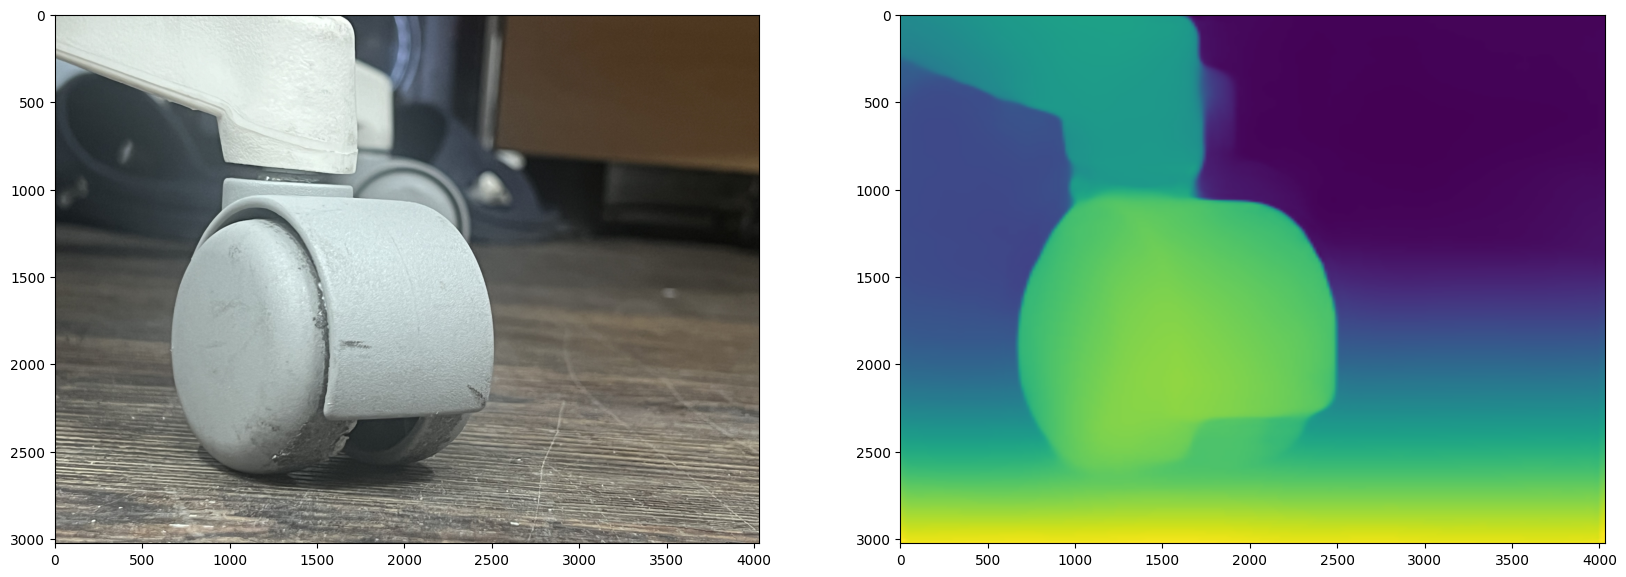

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(to_rgb(image))
ax[1].imshow(result_image);

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2  # For drawing rectangles
from matplotlib import pyplot as plt

In [ ]:
# params
center_area_size = (1500, 1500)  # Center area for obstacle detection
vertical_area_size = (100, 1000)  # Vertical area for directional control
depth_threshold = 70  # Example threshold, adjust based on depth range in your image

# to grayscale
depth_map = np.mean(result_image, axis=2)  # avg RGB
height, width = depth_map.shape

# center area
center_x, center_y = width // 2, height // 2
center_area = depth_map[
    center_y - center_area_size[1] // 2 : center_y + center_area_size[1] // 2,
    center_x - center_area_size[0] // 2 : center_x + center_area_size[0] // 2,
]

# min depth in center
min_depth = center_area.min()
obstacle_detected = min_depth < depth_threshold

# vertical area extract
vertical_area = depth_map[
    center_y - vertical_area_size[0] // 2 : center_y + vertical_area_size[0] // 2,
    :,
]

# weight for command
left_weights = np.linspace(1, 0, width // 2)  # High weight on left, decreasing to the center
right_weights = np.linspace(0, 1, width // 2)  # High weight on right, increasing from the center
forward_weights = np.concatenate([
    np.linspace(0, 1, width // 4),  # Low to high weight on the left quarter
    np.ones(width // 2),  # Uniform weight in the center
    np.linspace(1, 0, width // 4),  # High to low weight on the right quarter
])

# score for each dir
left_score = np.sum(vertical_area[:, :width // 2] * left_weights + 500)
right_score = np.sum(vertical_area[:, width // 2:] * right_weights + 500)
forward_score = np.sum(vertical_area * forward_weights)

# softmax (normalize score)
scores = torch.tensor([left_score, right_score, forward_score], dtype=torch.float32)
control_scores = F.softmax(scores, dim=0)

# control command
commands = ["Turn Right", "Turn Left", "Go Forward"]
command = commands[torch.argmax(control_scores).item()]

# print output
print(f"Obstacle Detected: {obstacle_detected}")
print(f"Control Command: {command}")

Obstacle Detected: True
Control Command: Turn Right


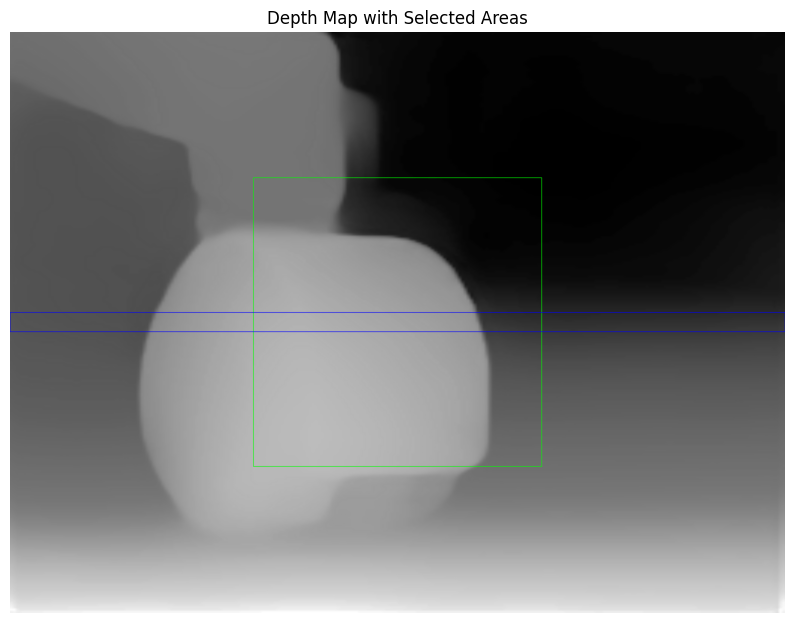

In [ ]:
# Assume `result_image` is the RGB output from MiDaS as a numpy array
# Convert to grayscale for depth processing
depth_map = np.mean(result_image, axis=2)  # Average RGB values to simulate depth

# Convert depth_map to uint8 for visualization
depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
depth_map_colored = cv2.cvtColor(depth_map_normalized, cv2.COLOR_GRAY2BGR)  # Convert to BGR for drawing

# Get the dimensions of the depth map
height, width = depth_map.shape

# Step 1: Extract the center area
center_x, center_y = width // 2, height // 2
center_area = depth_map[
    center_y - center_area_size[1] // 2 : center_y + center_area_size[1] // 2,
    center_x - center_area_size[0] // 2 : center_x + center_area_size[0] // 2,
]

# Draw the center area rectangle on the depth map
cv2.rectangle(
    depth_map_colored,
    (center_x - center_area_size[0] // 2, center_y - center_area_size[1] // 2),
    (center_x + center_area_size[0] // 2, center_y + center_area_size[1] // 2),
    (0, 255, 0),  # Green rectangle
    2,  # Line thickness
)

# Step 2: Extract the vertical area for directional control
vertical_area_top = center_y - vertical_area_size[0] // 2
vertical_area_bottom = center_y + vertical_area_size[0] // 2

# Draw the vertical area rectangle on the depth map
cv2.rectangle(
    depth_map_colored,
    (0, vertical_area_top),
    (width, vertical_area_bottom),
    (255, 0, 0),  # Blue rectangle
    2,  # Line thickness
)

# Visualize the depth map with rectangles
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(depth_map_colored, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
plt.title("Depth Map with Selected Areas")
plt.axis("off")
plt.show()

In [ ]:
# Convert depth result to binary map based on threshold
safety_distance = 50

# Ensure result_image is grayscale for binary conversion
if len(result_image.shape) == 3:  # Check if the image has a color channel
    grayscale_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2GRAY)
else:
    grayscale_image = result_image

# Create binary map
binary_map = np.where(grayscale_image < safety_distance, 1, 0)


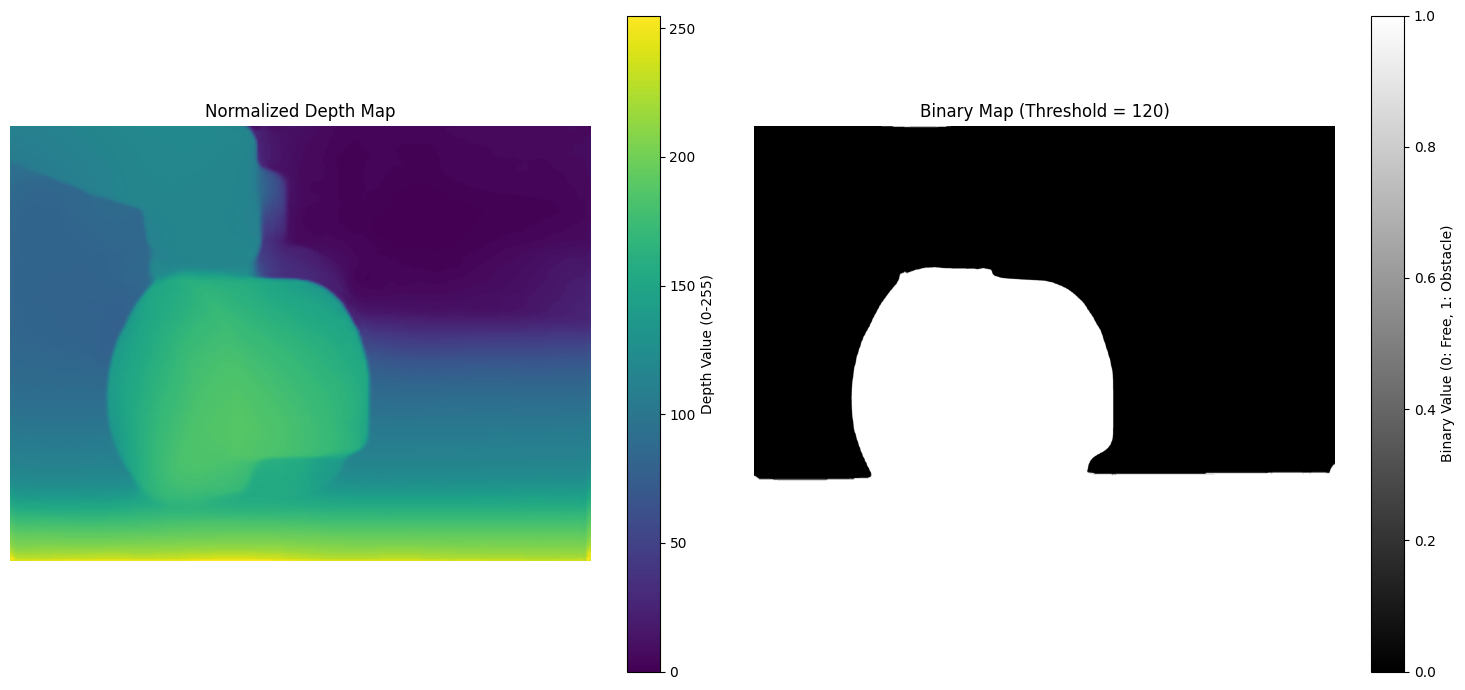

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Assume `result_image` is the RGB output from MiDaS as a numpy array
# Convert to grayscale for depth processing
depth_map = np.mean(result_image, axis=2)  # Average RGB values to simulate depth

# Assume `result_image` is the output from MiDaS as a grayscale depth map
# Normalize the depth map to [0, 255] for easier thresholding and visualization
normalized_depth = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Define the safety distance threshold
threshold_value = 120  # Adjust as needed for your scenario

# Apply binary thresholding: Values > 200 become 1, ≤ 200 become 0
_, binary_map = cv2.threshold(normalized_depth, threshold_value, 1, cv2.THRESH_BINARY)

# from google.colab.patches import cv2_imshow
# cv2_imshow(binary_map)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Visualize the normalized depth map and binary map with color bars
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Normalized Depth Map
norm_depth_plot = ax[0].imshow(normalized_depth, cmap="viridis")
ax[0].set_title("Normalized Depth Map")
ax[0].axis("off")
cbar = fig.colorbar(norm_depth_plot, ax=ax[0], orientation="vertical", label="Depth Value (0-255)")

# Binary Map
binary_map_plot = ax[1].imshow(binary_map, cmap="gray")
ax[1].set_title("Binary Map (Threshold = 120)")
ax[1].axis("off")
fig.colorbar(binary_map_plot, ax=ax[1], orientation="vertical", label="Binary Value (0: Free, 1: Obstacle)")

plt.tight_layout()
plt.show()


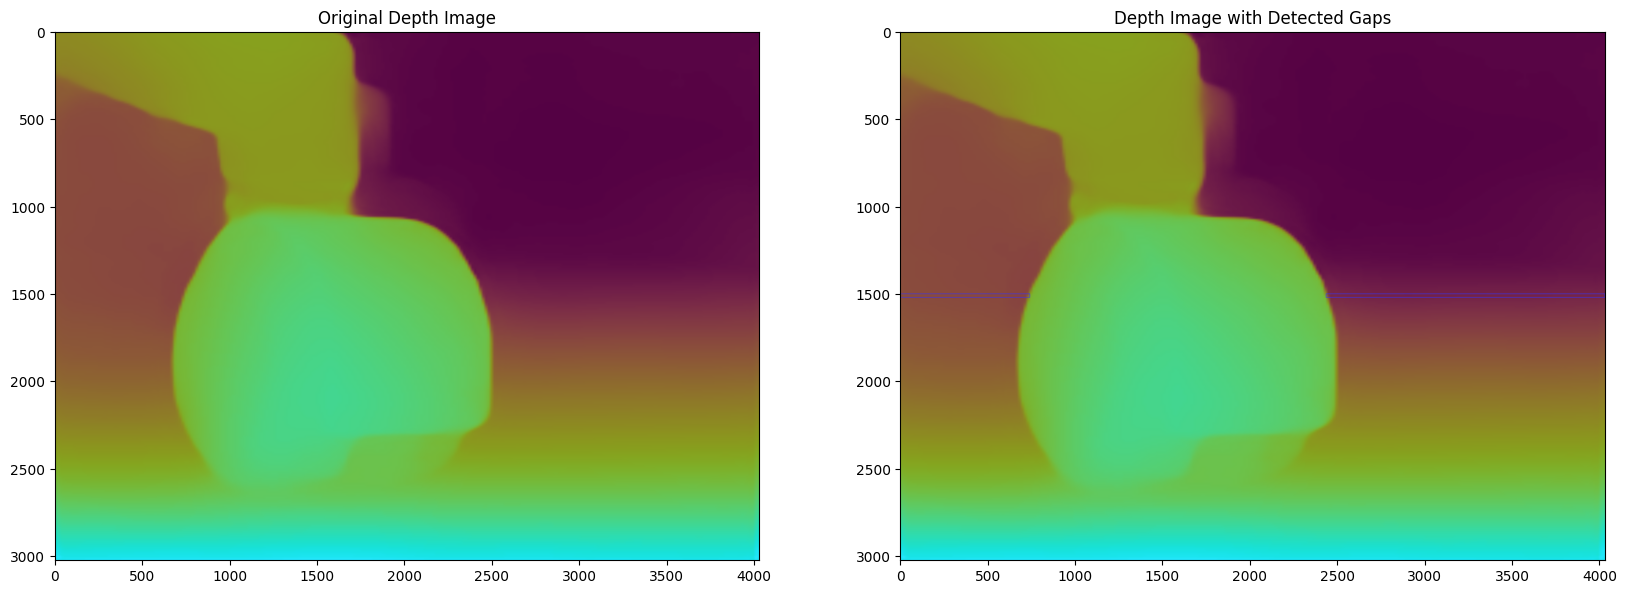

In [ ]:
# Function to detect gaps
def detect_gaps(binary_map):
    height, width = binary_map.shape
    horizontal_line = binary_map[height // 2]  # Define horizontal line at middle
    gaps = []
    current_gap = None

    for i, value in enumerate(horizontal_line):
        if value == 0:  # Free space
            if current_gap is None:
                current_gap = [i, i]
            else:
                current_gap[1] = i
        elif current_gap is not None:
            gaps.append(current_gap)
            current_gap = None

    if current_gap is not None:
        gaps.append(current_gap)

    return gaps

# Function to visualize gaps as rectangles on the depth image
def visualize_gaps(result_image, gaps):
    image_with_rectangles = result_image.copy()
    height, width, _ = image_with_rectangles.shape

    for gap in gaps:
        x1, x2 = gap
        cv2.rectangle(
            image_with_rectangles,
            (x1, height // 2 - 10),  # Top-left corner of rectangle
            (x2, height // 2 + 10),  # Bottom-right corner of rectangle
            (255, 50, 50),  # Color (green)
            2,  # Line thickness
        )
    return image_with_rectangles

# Convert depth result to binary map based on threshold
safety_distance = 100

# Ensure result_image is grayscale for binary conversion
if len(result_image.shape) == 3:  # Check if the image has a color channel
    grayscale_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2GRAY)
else:
    grayscale_image = result_image

# Detect gaps
gaps = detect_gaps(binary_map)

# Visualize gaps
result_with_gaps = visualize_gaps(result_image, gaps)

# Plot the original and result images
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Depth Image")
ax[1].imshow(cv2.cvtColor(result_with_gaps, cv2.COLOR_BGR2RGB))
ax[1].set_title("Depth Image with Detected Gaps")
plt.show()


**On video**

In [ ]:
# Video source: https://www.youtube.com/watch?v=fu1xcQdJRws (Public Domain)
VIDEO_FILE = "/content/241115_recording1.mp4"
# Number of seconds of input video to process. Set `NUM_SECONDS` to 0 to process
# the full video.
NUM_SECONDS = 10
# Set `ADVANCE_FRAMES` to 1 to process every frame from the input video
# Set `ADVANCE_FRAMES` to 2 to process every second frame. This reduces
# the time it takes to process the video.
ADVANCE_FRAMES = 2
# Set `SCALE_OUTPUT` to reduce the size of the result video
# If `SCALE_OUTPUT` is 0.5, the width and height of the result video
# will be half the width and height of the input video.
SCALE_OUTPUT = 0.5
# The format to use for video encoding. The 'vp09` is slow,
# but it works on most systems.
# Try the `THEO` encoding if you have FFMPEG installed.
# FOURCC = cv2.VideoWriter_fourcc(*"THEO")
FOURCC = cv2.VideoWriter_fourcc(*"vp09")

# Create Path objects for the input video and the result video.
output_directory = Path("output")
output_directory.mkdir(exist_ok=True)
result_video_path = output_directory / f"{Path(VIDEO_FILE).stem}_monodepth.mp4"

In [ ]:
cap = cv2.VideoCapture(str(VIDEO_FILE))
ret, image = cap.read()
if not ret:
    raise ValueError(f"The video at {VIDEO_FILE} cannot be read.")
input_fps = cap.get(cv2.CAP_PROP_FPS)
input_video_frame_height, input_video_frame_width = image.shape[:2]

target_fps = input_fps / ADVANCE_FRAMES
target_frame_height = int(input_video_frame_height * SCALE_OUTPUT)
target_frame_width = int(input_video_frame_width * SCALE_OUTPUT)

cap.release()
print(
    f"The input video has a frame width of {input_video_frame_width}, "
    f"frame height of {input_video_frame_height} and runs at {input_fps:.2f} fps"
)
print(
    "The monodepth video will be scaled with a factor "
    f"{SCALE_OUTPUT}, have width {target_frame_width}, "
    f" height {target_frame_height}, and run at {target_fps:.2f} fps"
)

The input video has a frame width of 640, frame height of 480 and runs at 30.00 fps
The monodepth video will be scaled with a factor 0.5, have width 320,  height 240, and run at 15.00 fps


In [ ]:
# Initialize variables.
input_video_frame_nr = 0
start_time = time.perf_counter()
total_inference_duration = 0

# Open the input video
cap = cv2.VideoCapture(str(VIDEO_FILE))

# Create a result video.
out_video = cv2.VideoWriter(
    str(result_video_path),
    FOURCC,
    target_fps,
    (target_frame_width * 2, target_frame_height),
)

num_frames = int(NUM_SECONDS * input_fps)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) if num_frames == 0 else num_frames
progress_bar = ProgressBar(total=total_frames)
progress_bar.display()

try:
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            cap.release()
            break

        if input_video_frame_nr >= total_frames:
            break

        # Only process every second frame.
        # Prepare a frame for inference.
        # Resize to the input shape for network.
        resized_image = cv2.resize(src=image, dsize=(network_image_height, network_image_width))

        # Reshape the image to network input shape NCHW.
        input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

        # Do inference.
        inference_start_time = time.perf_counter()
        result = compiled_model([input_image])[output_key]
        inference_stop_time = time.perf_counter()
        inference_duration = inference_stop_time - inference_start_time
        total_inference_duration += inference_duration

        if input_video_frame_nr % (10 * ADVANCE_FRAMES) == 0:
            clear_output(wait=True)
            progress_bar.display()
            # input_video_frame_nr // ADVANCE_FRAMES gives the number of
            # Frames that have been processed by the network.
            display(
                Pretty(
                    f"Processed frame {input_video_frame_nr // ADVANCE_FRAMES}"
                    f"/{total_frames // ADVANCE_FRAMES}. "
                    f"Inference time per frame: {inference_duration:.2f} seconds "
                    f"({1/inference_duration:.2f} FPS)"
                )
            )

        # Transform the network result to a RGB image.
        result_frame = to_rgb(convert_result_to_image(result))
        # Resize the image and the result to a target frame shape.
        result_frame = cv2.resize(result_frame, (target_frame_width, target_frame_height))
        image = cv2.resize(image, (target_frame_width, target_frame_height))

        # Put the image and the result side by side.
        stacked_frame = np.hstack((image, result_frame))
        # Save a frame to the video.
        out_video.write(stacked_frame)

        input_video_frame_nr = input_video_frame_nr + ADVANCE_FRAMES
        cap.set(1, input_video_frame_nr)

        progress_bar.progress = input_video_frame_nr
        progress_bar.update()

except KeyboardInterrupt:
    print("Processing interrupted.")
finally:
    clear_output()
    processed_frames = num_frames // ADVANCE_FRAMES
    out_video.release()
    cap.release()
    end_time = time.perf_counter()
    duration = end_time - start_time

    print(
        f"Processed {processed_frames} frames in {duration:.2f} seconds. "
        f"Total FPS (including video processing): {processed_frames/duration:.2f}."
        f"Inference FPS: {processed_frames/total_inference_duration:.2f} "
    )
    print(f"Monodepth Video saved to '{str(result_video_path)}'.")

Processed 150 frames in 69.86 seconds. Total FPS (including video processing): 2.15.Inference FPS: 5.91 
Monodepth Video saved to 'output/241115_recording1_monodepth.mp4'.


In [ ]:
result_video_path2 = output_directory / f"{Path(VIDEO_FILE).stem}_binary_withGapt.mp4"

In [ ]:
# Initialize variables.
input_video_frame_nr = 0
start_time = time.perf_counter()
total_inference_duration = 0

# Open the input video
cap = cv2.VideoCapture(str(VIDEO_FILE))

# Create a result video.
out_video = cv2.VideoWriter(
    str(result_video_path),
    FOURCC,
    target_fps,
    (target_frame_width * 2, target_frame_height),
)

num_frames = int(NUM_SECONDS * input_fps)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) if num_frames == 0 else num_frames
progress_bar = ProgressBar(total=total_frames)
progress_bar.display()

try:
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            cap.release()
            break

        if input_video_frame_nr >= total_frames:
            break

        # Only process every second frame.
        # Prepare a frame for inference.
        # Resize to the input shape for network.
        resized_image = cv2.resize(src=image, dsize=(network_image_height, network_image_width))
        # Reshape the image to network input shape NCHW.
        input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

        # Do inference.
        inference_start_time = time.perf_counter()
        result = compiled_model([input_image])[output_key]
        inference_stop_time = time.perf_counter()
        inference_duration = inference_stop_time - inference_start_time
        total_inference_duration += inference_duration

        if input_video_frame_nr % (10 * ADVANCE_FRAMES) == 0:
            clear_output(wait=True)
            progress_bar.display()
            # input_video_frame_nr // ADVANCE_FRAMES gives the number of
            # Frames that have been processed by the network.
            display(
                Pretty(
                    f"Processed frame {input_video_frame_nr // ADVANCE_FRAMES}"
                    f"/{total_frames // ADVANCE_FRAMES}. "
                    f"Inference time per frame: {inference_duration:.2f} seconds "
                    f"({1/inference_duration:.2f} FPS)"
                )
            )

        # Transform the network result to a RGB image.
        result_frame = to_rgb(convert_result_to_image(result))
        # Resize the image and the result to a target frame shape.
        result_frame = cv2.resize(result_frame, (target_frame_width, target_frame_height))
        image = cv2.resize(image, (target_frame_width, target_frame_height))



        normalized_depth = cv2.normalize(result_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        # Define the safety distance threshold
        threshold_value = 100  # Adjust as needed for your scenario
        # Apply binary thresholding: Values > 200 become 1, ≤ 200 become 0
        _, binary_map = cv2.threshold(normalized_depth, threshold_value, 1, cv2.THRESH_BINARY)
        # Convert depth result to binary map based on threshold
        safety_distance = 100
        # Detect gaps
        binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
        gaps = detect_gaps(binary_map)
        # Visualize gaps
        result_with_gaps = visualize_gaps(result_frame, gaps)


        # Put the image and the result side by side.
        stacked_frame = np.hstack((image, result_with_gaps))
        # Save a frame to the video.
        out_video.write(stacked_frame)

        input_video_frame_nr = input_video_frame_nr + ADVANCE_FRAMES
        cap.set(1, input_video_frame_nr)

        progress_bar.progress = input_video_frame_nr
        progress_bar.update()

except KeyboardInterrupt:
    print("Processing interrupted.")
finally:
    clear_output()
    processed_frames = num_frames // ADVANCE_FRAMES
    out_video.release()
    cap.release()
    end_time = time.perf_counter()
    duration = end_time - start_time

    print(
        f"Processed {processed_frames} frames in {duration:.2f} seconds. "
        f"Total FPS (including video processing): {processed_frames/duration:.2f}."
        f"Inference FPS: {processed_frames/total_inference_duration:.2f} "
    )
    print(f"Monodepth Video saved to '{str(result_video_path2)}'.")

Processed 150 frames in 69.30 seconds. Total FPS (including video processing): 2.16.Inference FPS: 6.04 
Monodepth Video saved to 'output/241115_recording1_binary_withGapt.mp4'.
